## EDA and Data Clean up

In [78]:
#Imports and Settings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.spatial.distance import mahalanobis
import warnings
warnings.filterwarnings('ignore')


# Settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
sns.set_theme(
    style="whitegrid",
    context="talk",
    palette="deep"
)

In [79]:
# Load Data

df = pd.read_csv('../data/raw/Wholesale_customers_data.csv')
df.shape[0], df.shape[1]

print(df.head(5))

   Channel  Region  Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicassen
0        2       3  12669  9656     7561     214              2674        1338
1        2       3   7057  9810     9568    1762              3293        1776
2        2       3   6353  8808     7684    2405              3516        7844
3        1       3  13265  1196     4221    6404               507        1788
4        2       3  22615  5410     7198    3915              1777        5185


### Data Cleaning

In [80]:
missing_values = df.isnull().sum()
if missing_values.sum() == 0:
    print("No missing values in the dataset.")
else:
    print("Missing values in each column:\n", missing_values)

duplicates = df.duplicated().sum()
if duplicates > 0:
    print("No duplicate records in the dataset.")
    df = df.drop_duplicates()
    print(f"New Shape: {df.shape}")
else:
    print(f"No duplicate")


# Defining Column Categories
categorical_cols = ['Channel', 'Region']
numerical_cols = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']

No missing values in the dataset.
No duplicate


In [81]:
# Stat Summary

print("\nNumerical Features Summary:")
print(df[numerical_cols].describe())

print("\nCategorical Features:")
print(f"\nChannel Distribution:")
print(df['Channel'].value_counts())
print(f"\nRegion Distribution:")
print(df['Region'].value_counts())


Numerical Features Summary:
               Fresh          Milk       Grocery        Frozen  \
count     440.000000    440.000000    440.000000    440.000000   
mean    12000.297727   5796.265909   7951.277273   3071.931818   
std     12647.328865   7380.377175   9503.162829   4854.673333   
min         3.000000     55.000000      3.000000     25.000000   
25%      3127.750000   1533.000000   2153.000000    742.250000   
50%      8504.000000   3627.000000   4755.500000   1526.000000   
75%     16933.750000   7190.250000  10655.750000   3554.250000   
max    112151.000000  73498.000000  92780.000000  60869.000000   

       Detergents_Paper    Delicassen  
count        440.000000    440.000000  
mean        2881.493182   1524.870455  
std         4767.854448   2820.105937  
min            3.000000      3.000000  
25%          256.750000    408.250000  
50%          816.500000    965.500000  
75%         3922.000000   1820.250000  
max        40827.000000  47943.000000  

Categorical Fea

In [82]:
# Customer Filters

# Filter by Channel
# Channel 1
channel_1 = df[df['Channel'] == 1]
print(f"Channel 1: {len(channel_1)} customers")

# Channel 2 
channel_2 = df[df['Channel'] == 2]
print(f"Channel 2: {len(channel_2)} customers")

# Filter by Region
# Region 1
region_1 = df[df['Region'] == 1]
print(f"Region 1: {len(region_1)} customers")

# Region 2
region_2 = df[df['Region'] == 2]
print(f"Region 2: {len(region_2)} customers")

# Region 3
region_3 = df[df['Region'] == 3]
print(f"Region 3: {len(region_3)} customers")

# Channel & Region Filter
# All combinations
for channel in [1, 2]:
    for region in [1, 2, 3]:
        subset = df[(df['Channel'] == channel) & (df['Region'] == region)]
        print(f"Channel {channel} & Region {region}: {len(subset):3d} customers")

# Summary Table by Channel & Region
print("\nSummary by Channel & Region:")
summary = []
for channel in sorted(df['Channel'].unique()):  # Sort channels
    for region in sorted(df['Region'].unique()):  # Sort regions
        subset = df[(df['Channel'] == channel) & (df['Region'] == region)]
        avg_total = subset[numerical_cols].sum(axis=1).mean()
        summary.append({
            'Segment': f"Channel {channel} & Region {region}",
            'Customers': len(subset),
            'Percentage': f"{len(subset)/len(df)*100:.1f}%",
            'Avg_Spending': f"${avg_total:,.0f}"
        })

summary_df = pd.DataFrame(summary)
print("\n", summary_df.to_string(index=False))


Channel 1: 298 customers
Channel 2: 142 customers
Region 1: 77 customers
Region 2: 47 customers
Region 3: 316 customers
Channel 1 & Region 1:  59 customers
Channel 1 & Region 2:  28 customers
Channel 1 & Region 3: 211 customers
Channel 2 & Region 1:  18 customers
Channel 2 & Region 2:  19 customers
Channel 2 & Region 3: 105 customers

Summary by Channel & Region:

              Segment  Customers Percentage Avg_Spending
Channel 1 & Region 1         59      13.4%      $26,074
Channel 1 & Region 2         28       6.4%      $25,684
Channel 1 & Region 3        211      48.0%      $27,214
Channel 2 & Region 1         18       4.1%      $47,137
Channel 2 & Region 2         19       4.3%      $43,997
Channel 2 & Region 3        105      23.9%      $47,005


In [83]:
# Distribution Analysis

# Skewness
print("\nSkewness of numerical features:")
for col in numerical_cols:
    skew = df[col].skew()
    print(f"  {col}: {skew:.2f}")


# Outlier Detection

outlier_summary = []
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outlier_count = len(outliers)
    outlier_pct = (outlier_count / len(df)) * 100
    
    outlier_summary.append({
        'Feature': col,
        'Outliers': outlier_count,
        'Percentage': f"{outlier_pct:.1f}%",
        'Lower_Bound': f"{lower_bound:.0f}",
        'Upper_Bound': f"{upper_bound:.0f}"
    })

outlier_df = pd.DataFrame(outlier_summary)
print("\n", outlier_df.to_string(index=False))


Skewness of numerical features:
  Fresh: 2.56
  Milk: 4.05
  Grocery: 3.59
  Frozen: 5.91
  Detergents_Paper: 3.63
  Delicassen: 11.15

          Feature  Outliers Percentage Lower_Bound Upper_Bound
           Fresh        20       4.5%      -17581       37643
            Milk        28       6.4%       -6953       15676
         Grocery        24       5.5%      -10601       23410
          Frozen        43       9.8%       -3476        7772
Detergents_Paper        30       6.8%       -5241        9420
      Delicassen        27       6.1%       -1710        3938



Correlation Matrix:
                     Fresh      Milk   Grocery    Frozen  Detergents_Paper  \
Fresh             1.000000  0.100510 -0.011854  0.345881         -0.101953   
Milk              0.100510  1.000000  0.728335  0.123994          0.661816   
Grocery          -0.011854  0.728335  1.000000 -0.040193          0.924641   
Frozen            0.345881  0.123994 -0.040193  1.000000         -0.131525   
Detergents_Paper -0.101953  0.661816  0.924641 -0.131525          1.000000   
Delicassen        0.244690  0.406368  0.205497  0.390947          0.069291   

                  Delicassen  
Fresh               0.244690  
Milk                0.406368  
Grocery             0.205497  
Frozen              0.390947  
Detergents_Paper    0.069291  
Delicassen          1.000000  

Highly Correlated Pairs (|r| > 0.6):
  Milk <-> Grocery: 0.728
  Milk <-> Detergents_Paper: 0.662
  Grocery <-> Detergents_Paper: 0.925

Overall Correlation Heatmap:


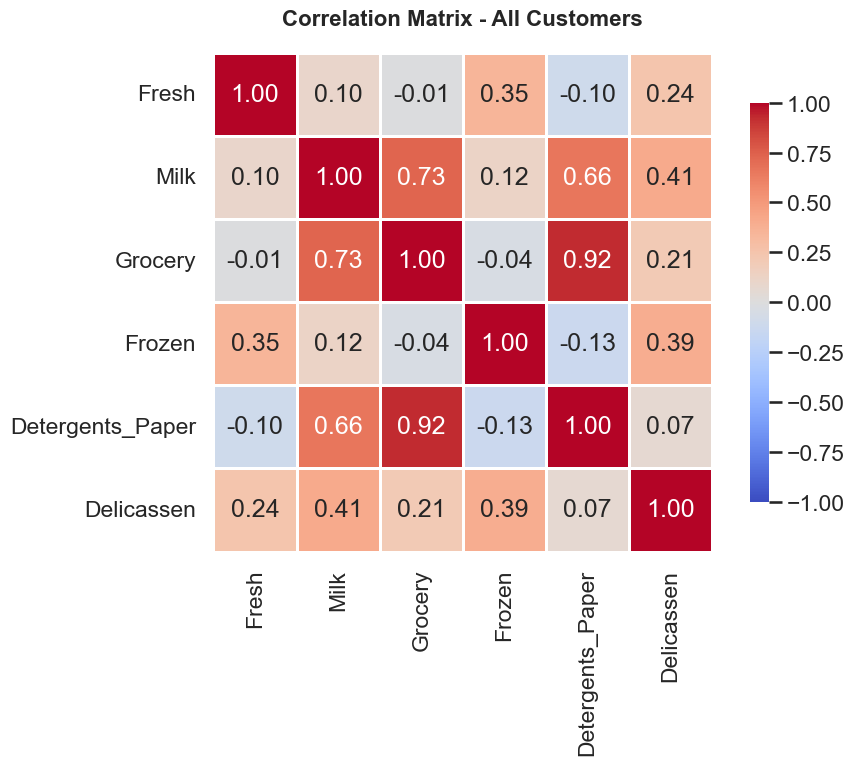


Correlation by Channel:


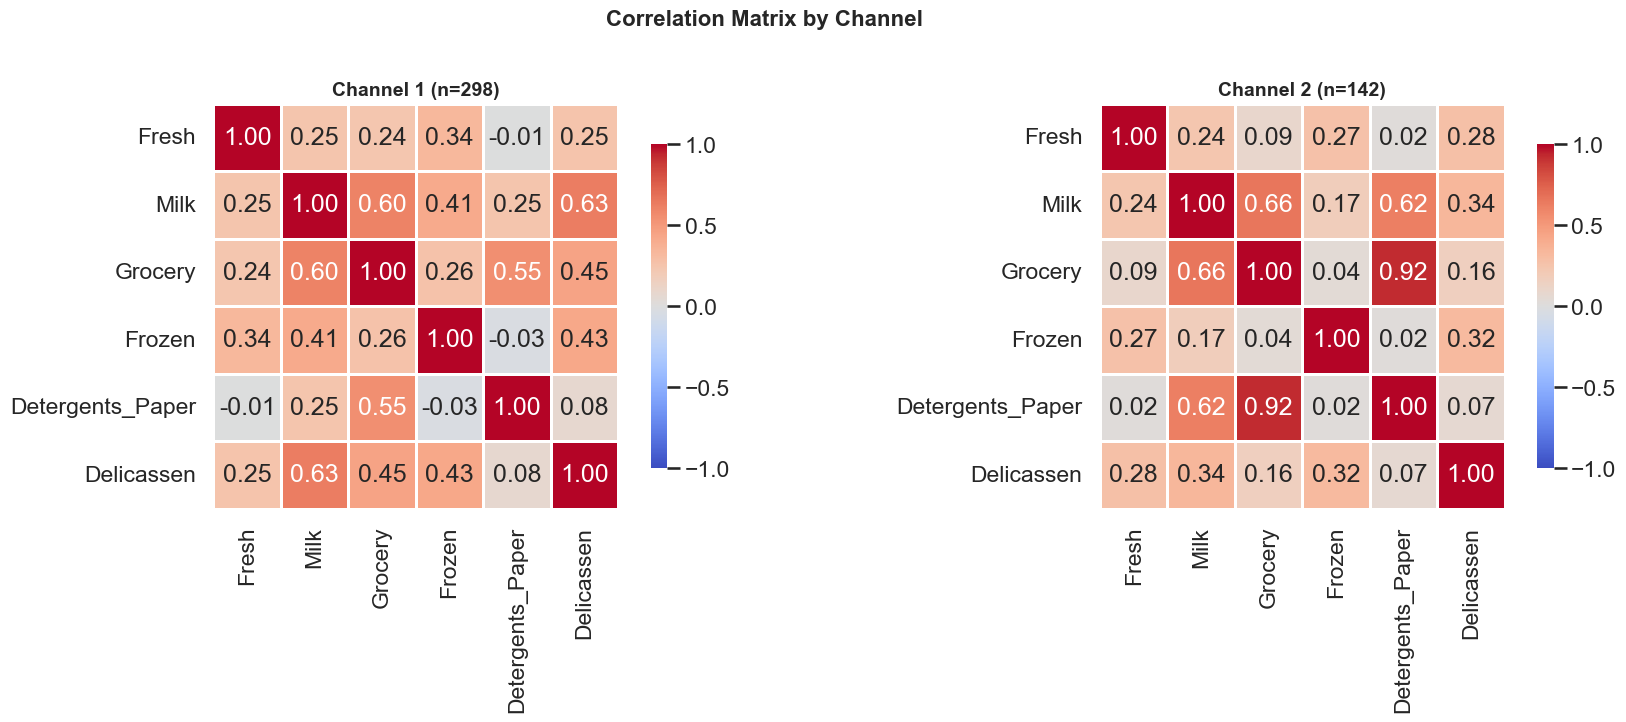


Correlation by Region:


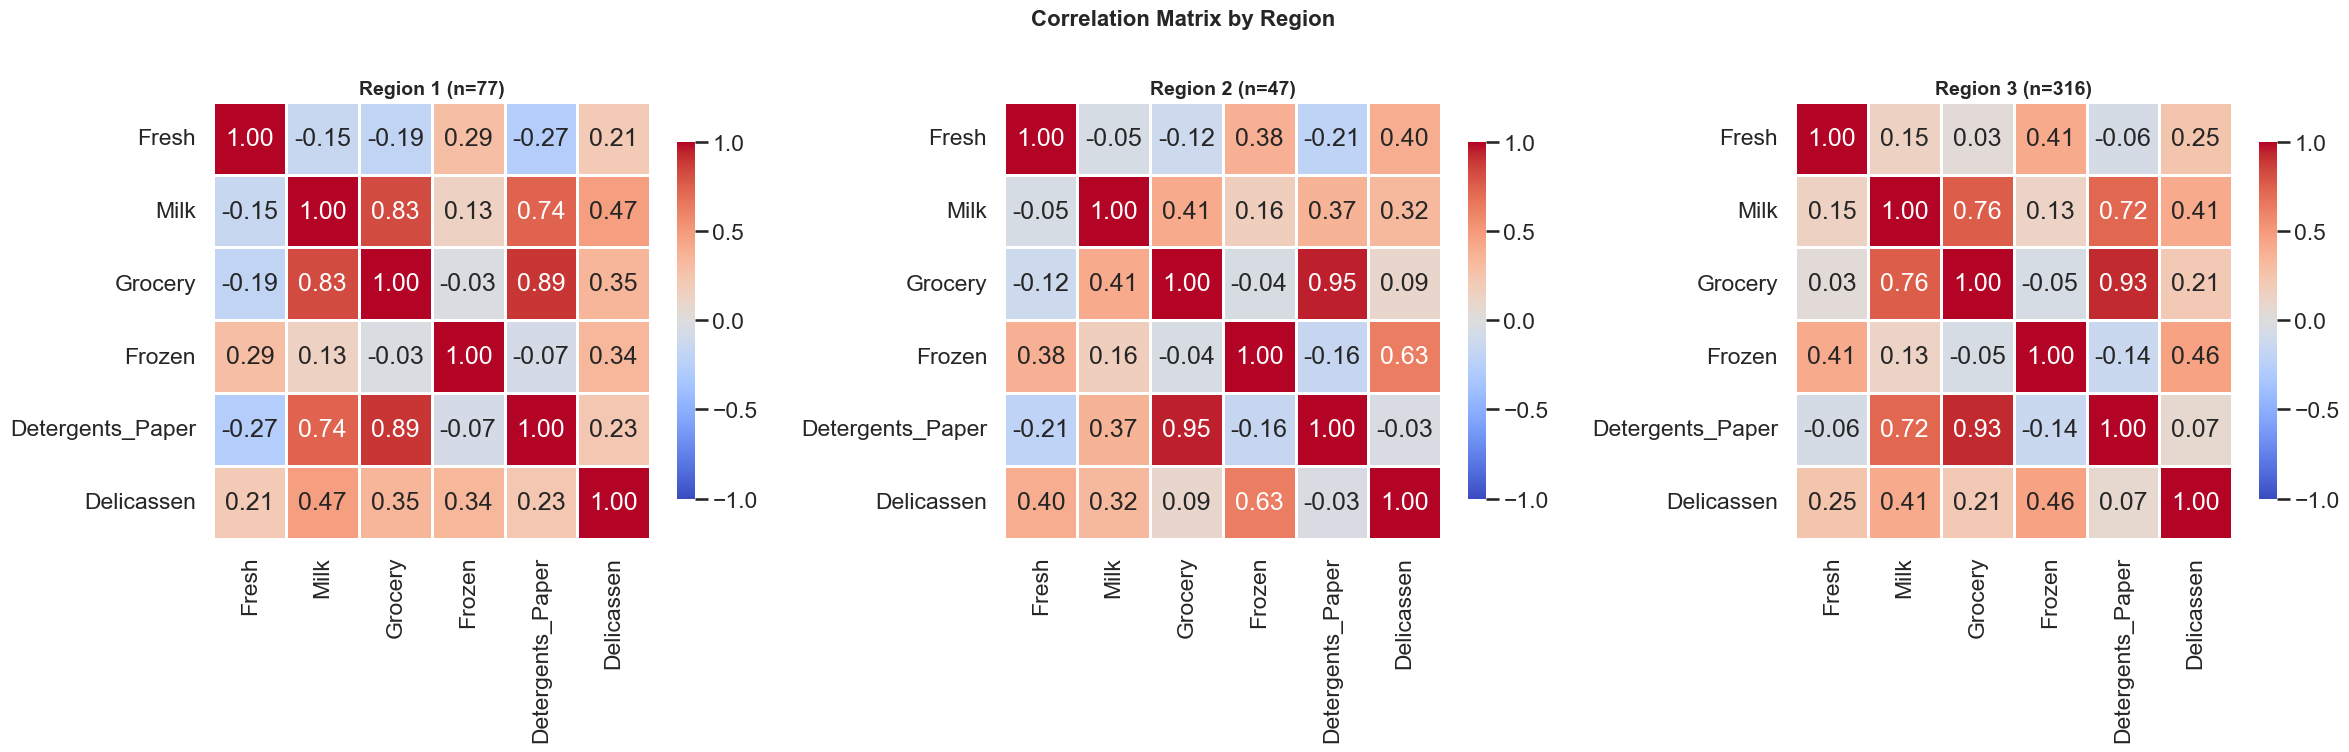


Correlation by Channel & Region:
✓ Saved: correlation_by_channel_region.png


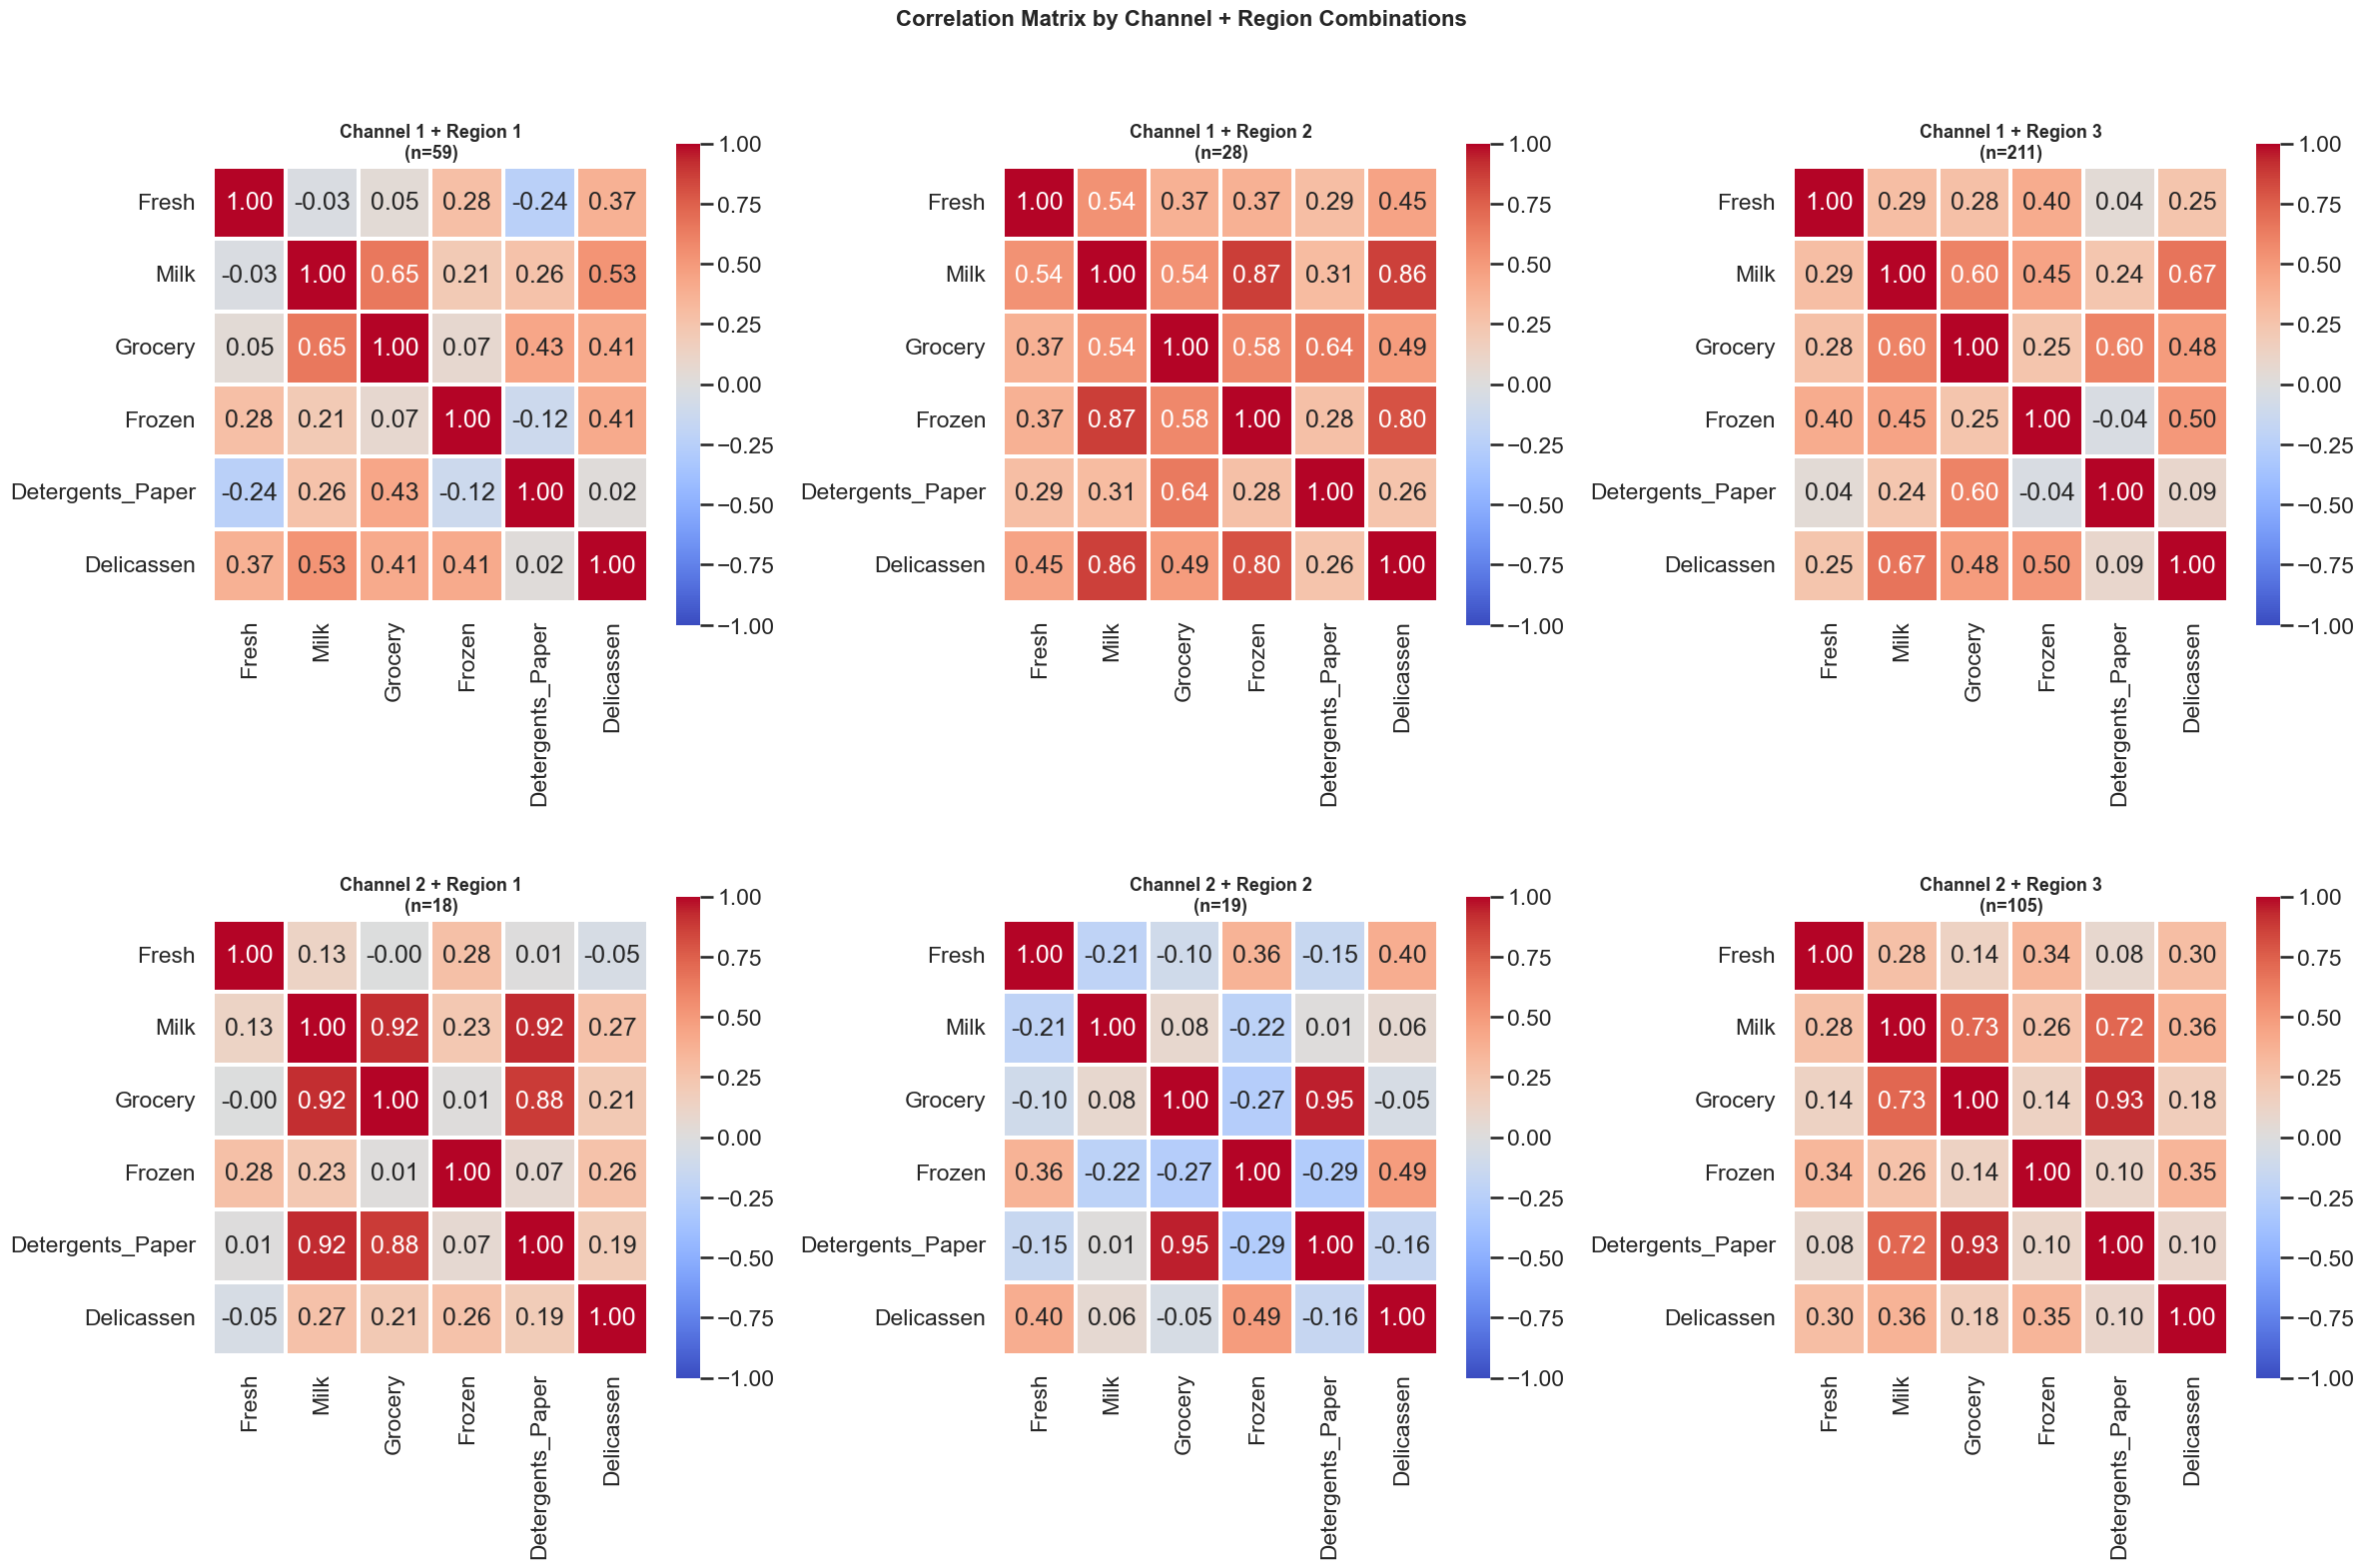

In [84]:
# Correlation Analysis
correlation = df[numerical_cols].corr()
print("\nCorrelation Matrix:")
print(correlation)

# Find high correlations
print("\nHighly Correlated Pairs (|r| > 0.6):")
threshold = 0.6
found_high_corr = False
for i in range(len(correlation.columns)):
    for j in range(i+1, len(correlation.columns)):
        if abs(correlation.iloc[i, j]) > threshold:
            print(f"  {correlation.columns[i]} <-> {correlation.columns[j]}: {correlation.iloc[i, j]:.3f}")
            found_high_corr = True

if not found_high_corr:
    print("  No pairs with |correlation| > 0.6")

# Overall Correlation Heatmap
print("\nOverall Correlation Heatmap:")
plt.figure(figsize=(10, 8))
correlation = df[numerical_cols].corr()
sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm', 
            square=True, linewidths=2, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix - All Customers', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('../results/correlation_overall.png', dpi=300, bbox_inches='tight')
plt.show()

# Correlation by Channel
print("\nCorrelation by Channel:")
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

for idx, channel in enumerate([1, 2]):
    df_channel = df[df['Channel'] == channel]
    corr_channel = df_channel[numerical_cols].corr()
    
    sns.heatmap(corr_channel, annot=True, fmt='.2f', cmap='coolwarm',
                square=True, linewidths=2, ax=axes[idx],
                vmin=-1, vmax=1, center=0, cbar_kws={"shrink": 0.8})
    axes[idx].set_title(f'Channel {channel} (n={len(df_channel)})', 
                       fontsize=14, fontweight='bold')

plt.suptitle('Correlation Matrix by Channel', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../results/correlation_by_channel.png', dpi=300, bbox_inches='tight')
plt.show()


# Correlation by Region
print("\nCorrelation by Region:")
regions = sorted(df['Region'].unique())
fig, axes = plt.subplots(1, 3, figsize=(24, 7))

for idx, region in enumerate(regions):
    df_region = df[df['Region'] == region]
    corr_region = df_region[numerical_cols].corr()
    
    sns.heatmap(corr_region, annot=True, fmt='.2f', cmap='coolwarm',
                square=True, linewidths=2, ax=axes[idx],
                vmin=-1, vmax=1, center=0, cbar_kws={"shrink": 0.8})
    axes[idx].set_title(f'Region {region} (n={len(df_region)})', 
                       fontsize=14, fontweight='bold')

plt.suptitle('Correlation Matrix by Region', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../results/correlation_by_region.png', dpi=300, bbox_inches='tight')
plt.show()


# Correlation - Channel & Region Combined
print("\nCorrelation by Channel & Region:")
combinations = []
for channel in sorted(df['Channel'].unique()):
    for region in sorted(df['Region'].unique()):
        subset = df[(df['Channel'] == channel) & (df['Region'] == region)]
        if len(subset) >= 10:  # Only include if we have at least 10 samples
            combinations.append((channel, region, len(subset)))

n_combinations = len(combinations)
n_cols = 3
n_rows = (n_combinations + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(24, 8*n_rows))
axes = axes.flatten() if n_combinations > 1 else [axes]

for idx, (channel, region, count) in enumerate(combinations):
    df_subset = df[(df['Channel'] == channel) & (df['Region'] == region)]
    corr_subset = df_subset[numerical_cols].corr()
    
    sns.heatmap(corr_subset, annot=True, fmt='.2f', cmap='coolwarm',
                square=True, linewidths=1.5, ax=axes[idx],
                vmin=-1, vmax=1, center=0, cbar_kws={"shrink": 0.8})
    axes[idx].set_title(f'Channel {channel} + Region {region}\n(n={count})', 
                       fontsize=13, fontweight='bold')

# Hide any unused subplots
for idx in range(n_combinations, len(axes)):
    axes[idx].axis('off')

plt.suptitle('Correlation Matrix by Channel + Region Combinations', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('../results/correlation_by_channel_region.png', dpi=300, bbox_inches='tight')
print("✓ Saved: correlation_by_channel_region.png")
plt.show()

### Key Findings from Correlation Analysis

1. Overall Pattern (All Customers)

    - Grocery <> Detergents_Paper: 0.92 (VERY strong! Almost moving together)
    - Milk <> Grocery: 0.73
    - Milk <> Detergents_Paper: 0.66

2. Channel Differences
    - Channel 1 (Hotels/Restaurants - 298 customers):
        - Weaker Grocery <> Detergents correlation (0.55 vs 0.92 in Channel 2)
        - Strong Milk<>Delicassen (0.63) - unique to this channel!

    - Channel 2 (Retail - 142 customers):
        - Extremely strong Grocery <> Detergents (0.92)
        - Typical retail shopping pattern

3. Regional Variations
    - Region 2 shows Frozen <> Delicassen correlation (0.63)
    - All regions maintain strong Grocery <> Detergents correlation

4. Most Interesting Combo: Channel 1 + Region 2 (28 customers)
    - Milk-Frozen: 0.87
    - Milk-Delicassen: 0.86
    - Frozen-Delicassen: 0.80
    - This is a VERY distinct customer group!

5. Implications for My Clustering:
    Should I segment by Channel/Region first?
    - Pros:
        - Very different correlation patterns suggest different customer behaviors
        - Channel 1 + Region 2 is clearly unique (might get lost in overall clustering)
        - More interpretable segments (e.g., "Region 3 Retailers")

    - Cons:
        - Smaller sample sizes (Channel 2 + Region 1 = only 18 customers)
        - More complex analysis
        - Might over-segment

6. My Plan Options:
    - Option A: Cluster overall first, then analyze if clusters align with Channel/Region
    - Option B: Create separate models for Channel 1 vs Channel 2 (strong enough difference)
    - Option C: Add Channel/Region as features in clustering (one-hot encoded)


Average Spending by Channel:
                Fresh          Milk       Grocery       Frozen  \
Channel                                                          
1        13475.560403   3451.724832   3962.137584  3748.251678   
2         8904.323944  10716.500000  16322.852113  1652.612676   

         Detergents_Paper   Delicassen  
Channel                                 
1              790.560403  1415.956376  
2             7269.507042  1753.436620  

Average Spending by Region:
               Fresh         Milk      Grocery       Frozen  Detergents_Paper  \
Region                                                                          
1       11101.727273  5486.415584  7403.077922  3000.337662       2651.116883   
2        9887.680851  5088.170213  9218.595745  4045.361702       3687.468085   
3       12533.471519  5977.085443  7896.363924  2944.594937       2817.753165   

         Delicassen  
Region               
1       1354.896104  
2       1159.702128  
3       1620.60126

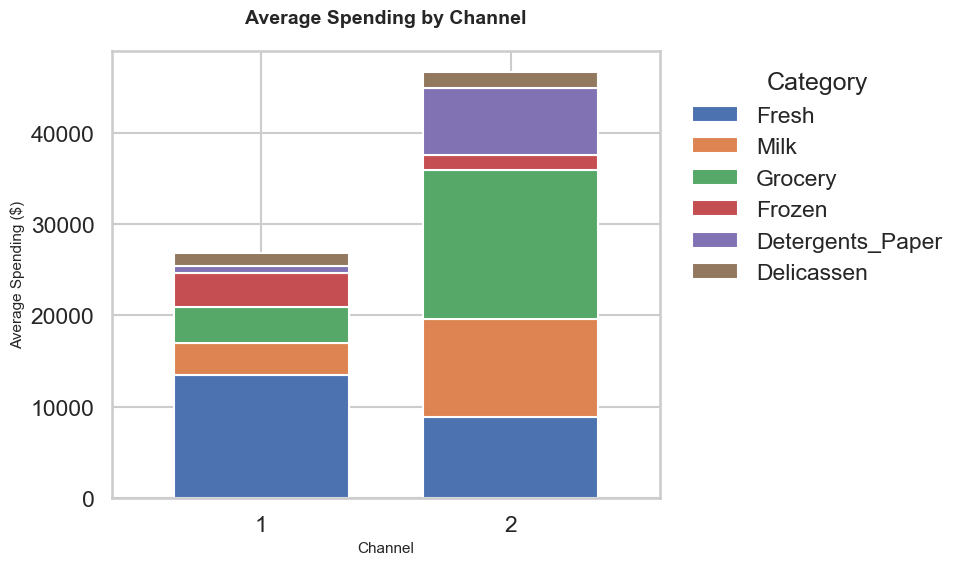

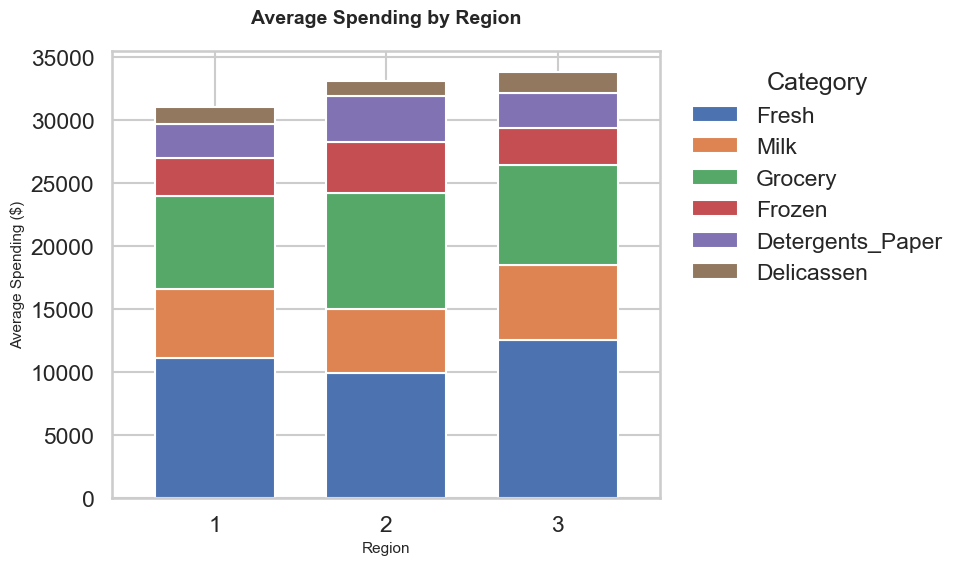

In [85]:
# Channel & Region Analysis

print("\nAverage Spending by Channel:")
channel_spending = df.groupby('Channel')[numerical_cols].mean()
print(channel_spending)

print("\nAverage Spending by Region:")
region_spending = df.groupby('Region')[numerical_cols].mean()
print(region_spending)

channel_df = (
    channel_spending
    .reset_index()
    .melt(
        id_vars="Channel",
        var_name="Category",
        value_name="Average Spending"
    )
)
region_df = (
    region_spending
    .reset_index()
    .melt(
        id_vars="Region",
        var_name="Category",
        value_name="Average Spending"
    )
)

def plot_stacked_spending(df_grouped, title, xlabel, filename):
    ax = df_grouped.plot(
        kind='bar', 
        stacked=True, 
        figsize=(10, 6),
        width=0.7,
        edgecolor='white'
    )
    plt.title(title, fontweight="bold", fontsize=14, pad=20)
    plt.xlabel(xlabel, fontsize=11)
    plt.ylabel("Average Spending ($)", fontsize=11)
    plt.xticks(rotation=0)
    

    plt.legend(
        title="Category", 
        bbox_to_anchor=(1.02, 1), 
        loc='upper left', 
        frameon=False
    )

    for rect in ax.patches:
        pass

    plt.tight_layout()
    plt.savefig(f"../results/{filename}.png", dpi=300, bbox_inches="tight")
    plt.show()

# 1. Plot for Channel
plot_stacked_spending(
    channel_spending, 
    "Average Spending by Channel", 
    "Channel", 
    "stacked_spending_channel"
)

# 2. Plot for Region
plot_stacked_spending(
    region_spending, 
    "Average Spending by Region", 
    "Region", 
    "stacked_spending_region"
)

In [86]:
# Total Spend

df['Total_Spend'] = df[numerical_cols].sum(axis=1)

print(f"\nTotal Spending Statistics:")
print(f"  Mean: ${df['Total_Spend'].mean():,.0f}")
print(f"  Median: ${df['Total_Spend'].median():,.0f}")
print(f"  Std Dev: ${df['Total_Spend'].std():,.0f}")
print(f"  Min: ${df['Total_Spend'].min():,.0f}")
print(f"  Max: ${df['Total_Spend'].max():,.0f}")


Total Spending Statistics:
  Mean: $33,226
  Median: $27,492
  Std Dev: $26,356
  Min: $904
  Max: $199,891


In [87]:
# Findings

avg_spending = df[numerical_cols].mean().sort_values(ascending=False)

print("\n1. DATA QUALITY:")
print(f"   • Total customers: {len(df)}")
print(f"   • No missing values")
print(f"   • No duplicates")

print("\n2. DISTRIBUTION:")
print("   • All features are right-skewed (positive skewness)")
print("   • Significant outliers present in most categories")
print("   • Large variance in spending patterns")

print("\n3. CHANNEL DISTRIBUTION:")
print(f"   • Channel 1: {(df['Channel']==1).sum()} customers ({(df['Channel']==1).sum()/len(df)*100:.1f}%)")
print(f"   • Channel 2: {(df['Channel']==2).sum()} customers ({(df['Channel']==2).sum()/len(df)*100:.1f}%)")

print("\n4. SPENDING PATTERNS:")
print(f"   • Highest avg spending: {avg_spending.index[0]} (${avg_spending.values[0]:,.0f})")
print(f"   • Lowest avg spending: {avg_spending.index[-1]} (${avg_spending.values[-1]:,.0f})")
print(f"   • Average total spending: ${df['Total_Spend'].mean():,.0f}")


1. DATA QUALITY:
   • Total customers: 440
   • No missing values
   • No duplicates

2. DISTRIBUTION:
   • All features are right-skewed (positive skewness)
   • Significant outliers present in most categories
   • Large variance in spending patterns

3. CHANNEL DISTRIBUTION:
   • Channel 1: 298 customers (67.7%)
   • Channel 2: 142 customers (32.3%)

4. SPENDING PATTERNS:
   • Highest avg spending: Fresh ($12,000)
   • Lowest avg spending: Delicassen ($1,525)
   • Average total spending: $33,226


#### Outlier Deep Dive


Fresh:
  Bounds: [-17581, 37643]
  Outliers: 20 customers (4.5%)
  Outlier values range: $38,793 - $112,151

Milk:
  Bounds: [-6953, 15676]
  Outliers: 28 customers (6.4%)
  Outlier values range: $15,726 - $73,498

Grocery:
  Bounds: [-10601, 23410]
  Outliers: 24 customers (5.5%)
  Outlier values range: $23,596 - $92,780

Frozen:
  Bounds: [-3476, 7772]
  Outliers: 43 customers (9.8%)
  Outlier values range: $7,782 - $60,869

Detergents_Paper:
  Bounds: [-5241, 9420]
  Outliers: 30 customers (6.8%)
  Outlier values range: $9,529 - $40,827

Delicassen:
  Bounds: [-1710, 3938]
  Outliers: 27 customers (6.1%)
  Outlier values range: $4,100 - $47,943

Total unique customers with at least 1 outlier feature: 108

Outlier frequency distribution:
  6 features: 1 customers
  4 features: 3 customers
  3 features: 13 customers
  2 features: 24 customers
  1 features: 67 customers

Top 10 Extreme Outliers (outliers in most categories):
 Customer_ID  Outlier_Features                              

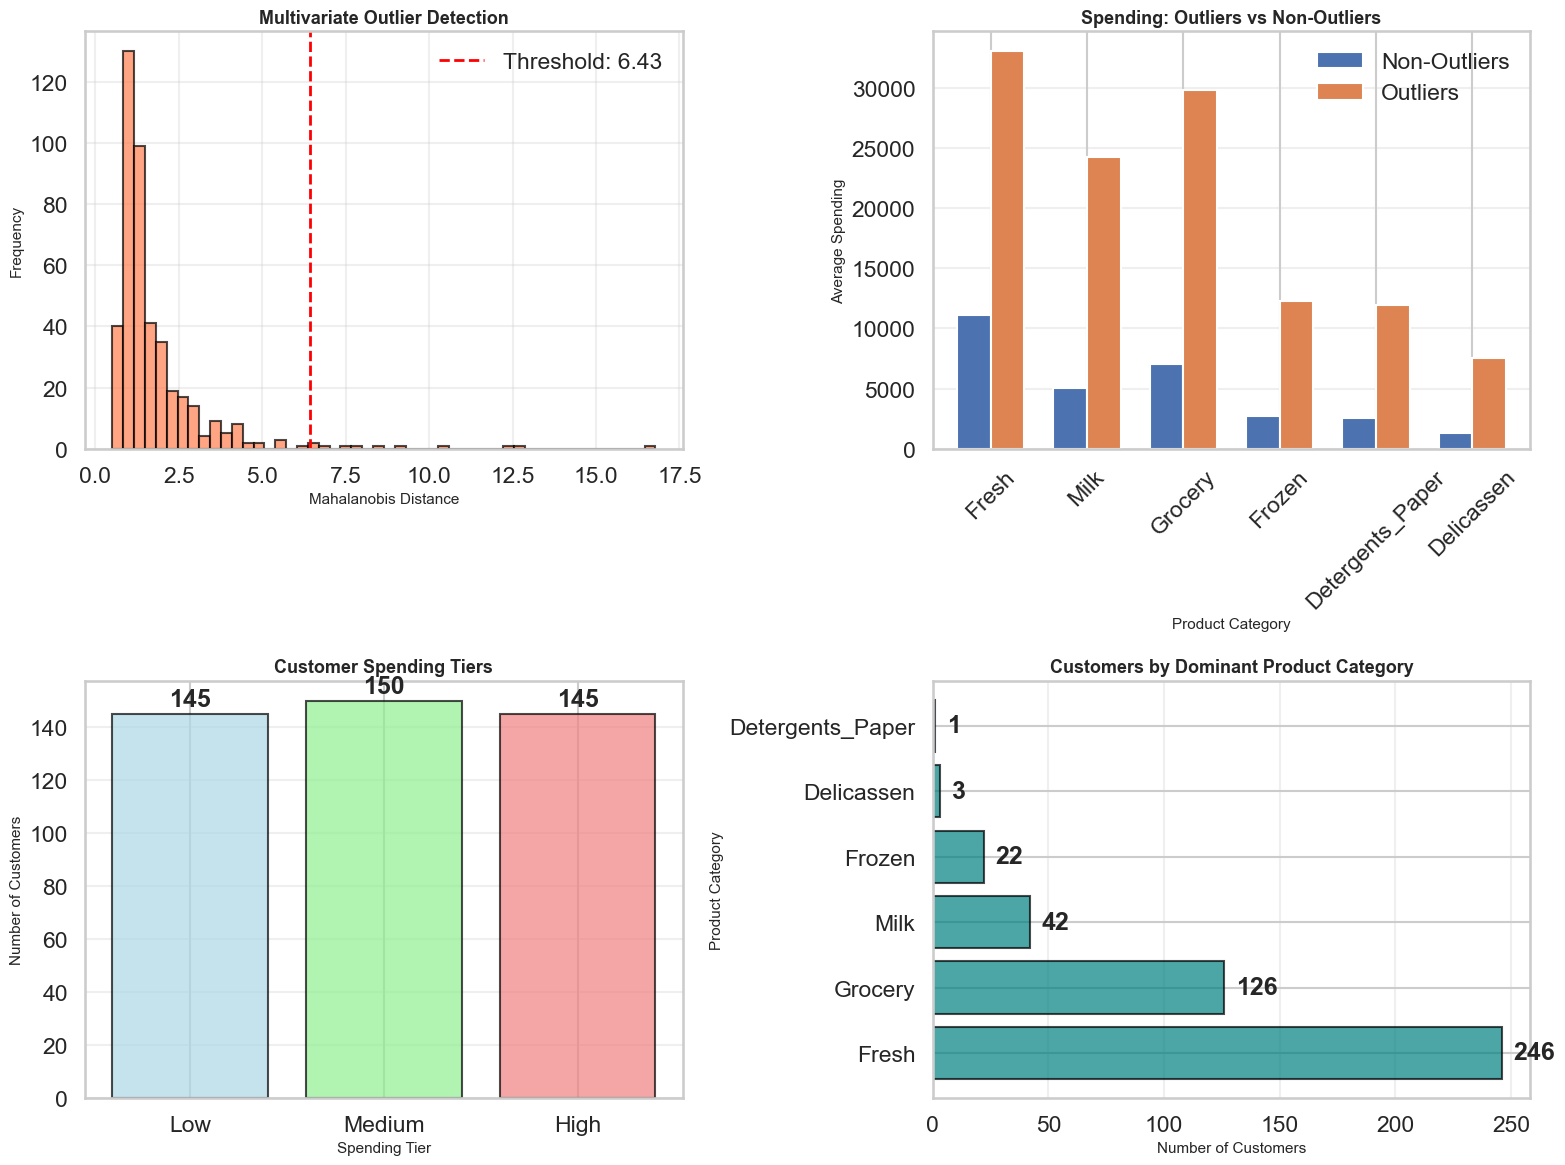

In [99]:
# Outlier Detection - Univariate (IQR Method)

# Identifying Univariate Outliers
outlier_indices = {}
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index.tolist()
    outlier_indices[col] = outliers
    
    print(f"\n{col}:")
    print(f"  Bounds: [{lower_bound:.0f}, {upper_bound:.0f}]")
    print(f"  Outliers: {len(outliers)} customers ({len(outliers)/len(df)*100:.1f}%)")
    if len(outliers) > 0:
        print(f"  Outlier values range: ${df.loc[outliers, col].min():,.0f} - ${df.loc[outliers, col].max():,.0f}")

# Finding Customers with Multiple Outlier Features

all_outlier_indices = set()
for indices in outlier_indices.values():
    all_outlier_indices.update(indices)

outlier_counts = {}
for idx in all_outlier_indices:
    count = sum([idx in outlier_indices[col] for col in numerical_cols])
    outlier_counts[idx] = count

# Sorting by num of outlier features
sorted_outliers = sorted(outlier_counts.items(), key=lambda x: x[1], reverse=True)

print(f"\nTotal unique customers with at least 1 outlier feature: {len(all_outlier_indices)}")
print(f"\nOutlier frequency distribution:")
for i in range(6, 0, -1):
    count = sum([1 for _, v in sorted_outliers if v == i])
    if count > 0:
        print(f"  {i} features: {count} customers")

# Top 10 extreme outliers
print(f"\nTop 10 Extreme Outliers (outliers in most categories):")
top_outliers = sorted_outliers[:10]
outlier_details = []
for idx, num_outliers in top_outliers:
    outlier_features = [col for col in numerical_cols if idx in outlier_indices[col]]
    total_spending = df.loc[idx, numerical_cols].sum()
    outlier_details.append({
        'Customer_ID': idx,
        'Outlier_Features': num_outliers,
        'Features': ', '.join(outlier_features),
        'Total_Spending': f"${total_spending:,.0f}",
        'Channel': df.loc[idx, 'Channel'],
        'Region': df.loc[idx, 'Region']
    })

outlier_df = pd.DataFrame(outlier_details)
print(outlier_df.to_string(index=False))

#Multivariate outlier detection (Mahalanobis distance)

# Data Standardization
X = df[numerical_cols].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Covariance matrix
cov_matrix = np.cov(X_scaled.T)
inv_cov_matrix = np.linalg.inv(cov_matrix)

# Mahalanobis distance for each point
mean = np.mean(X_scaled, axis=0)
mahal_distances = []
for i in range(len(X_scaled)):
    mahal_dist = mahalanobis(X_scaled[i], mean, inv_cov_matrix)
    mahal_distances.append(mahal_dist)

df['Mahalanobis_Distance'] = mahal_distances

# Determine threshold (chi-square distribution with p=0.001)
threshold = np.sqrt(stats.chi2.ppf(0.999, df=len(numerical_cols)))
multivariate_outliers = df[df['Mahalanobis_Distance'] > threshold]

print(f"Threshold (p=0.001): {threshold:.2f}")
print(f"Multivariate outliers: {len(multivariate_outliers)} customers ({len(multivariate_outliers)/len(df)*100:.1f}%)")
print(f"\nTop 5 Multivariate Outliers:")
top_mahal = df.nlargest(5, 'Mahalanobis_Distance')[['Mahalanobis_Distance', 'Channel', 'Region'] + numerical_cols]
print(top_mahal)

# Outlier characteristics

df['Is_Outlier'] = df['Mahalanobis_Distance'] > threshold

print("\nAverage Spending Comparison:")
comparison = df.groupby('Is_Outlier')[numerical_cols].mean()
comparison.index = ['Non-Outliers', 'Outliers']
print(comparison)

print("\n\nChannel/Region Distribution:")
print("\nOutliers by Channel:")
print(pd.crosstab(df['Is_Outlier'], df['Channel'], normalize='index') * 100)
print("\nOutliers by Region:")
print(pd.crosstab(df['Is_Outlier'], df['Region'], normalize='index') * 100)

# Visuals

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Mahalanobis distance distribution
axes[0, 0].hist(df['Mahalanobis_Distance'], bins=50, edgecolor='black', alpha=0.7, color='coral')
threshold = np.sqrt(41.4)  # chi-square threshold
axes[0, 0].axvline(threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold: {threshold:.2f}')
axes[0, 0].set_xlabel('Mahalanobis Distance', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].set_title('Multivariate Outlier Detection', fontsize=13, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Outlier vs Non-outlier spending comparison
outlier_comparison = df.groupby('Is_Outlier')[numerical_cols].mean()
outlier_comparison.T.plot(kind='bar', ax=axes[0, 1], width=0.7)
axes[0, 1].set_title('Spending: Outliers vs Non-Outliers', fontsize=13, fontweight='bold')
axes[0, 1].set_xlabel('Product Category', fontsize=11)
axes[0, 1].set_ylabel('Average Spending', fontsize=11)
axes[0, 1].legend(['Non-Outliers', 'Outliers'])
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. Spending tiers distribution
tier_counts = df['Spending_Tier'].value_counts().sort_index()
colors = ['lightblue', 'lightgreen', 'lightcoral']
axes[1, 0].bar(tier_counts.index, tier_counts.values, color=colors, edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Customer Spending Tiers', fontsize=13, fontweight='bold')
axes[1, 0].set_xlabel('Spending Tier', fontsize=11)
axes[1, 0].set_ylabel('Number of Customers', fontsize=11)
axes[1, 0].grid(True, alpha=0.3, axis='y')
for i, (tier, count) in enumerate(tier_counts.items()):
    axes[1, 0].text(i, count + 3, str(count), ha='center', fontweight='bold')

# 4. Dominant category distribution
dom_cat = df['Dominant_Category'].value_counts()
axes[1, 1].barh(dom_cat.index, dom_cat.values, color='teal', edgecolor='black', alpha=0.7)
axes[1, 1].set_title('Customers by Dominant Product Category', fontsize=13, fontweight='bold')
axes[1, 1].set_xlabel('Number of Customers', fontsize=11)
axes[1, 1].set_ylabel('Product Category', fontsize=11)
axes[1, 1].grid(True, alpha=0.3, axis='x')
for i, (cat, count) in enumerate(dom_cat.items()):
    axes[1, 1].text(count + 5, i, str(count), va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('../results/analysis_1_outliers_behavior.png', dpi=300, bbox_inches='tight')
plt.show()


#### Spending Analysis

In [89]:
# Total Spending Statistics

df['Total_Spending'] = df[numerical_cols].sum(axis=1)

print(f"Mean Total Spending: ${df['Total_Spending'].mean():,.0f}")
print(f"Median Total Spending: ${df['Total_Spending'].median():,.0f}")
print(f"Std Dev: ${df['Total_Spending'].std():,.0f}")
print(f"Min: ${df['Total_Spending'].min():,.0f}")
print(f"Max: ${df['Total_Spending'].max():,.0f}")

# Percentiles
percentiles = [10, 25, 50, 75, 90, 95, 99]
print(f"\nSpending Percentiles:")
for p in percentiles:
    value = df['Total_Spending'].quantile(p/100)
    print(f"  {p}th percentile: ${value:,.0f}")

# Customer value segmentation

# Spending Tiers
df['Spending_Tier'] = pd.cut(df['Total_Spending'], 
                              bins=[0, df['Total_Spending'].quantile(0.33), 
                                    df['Total_Spending'].quantile(0.67), 
                                    df['Total_Spending'].max()],
                              labels=['Low', 'Medium', 'High'])

print("\nSpending Tier Distribution:")
tier_stats = df.groupby('Spending_Tier').agg({
    'Total_Spending': ['count', 'mean', 'min', 'max']
}).round(0)
print(tier_stats)

# Product category dominance

# Find dominant category for each customer
print("\n Product Dominance Analysis")
df['Dominant_Category'] = df[numerical_cols].idxmax(axis=1)

print("Customer Distribution by Dominant Category:")
dom_cat_dist = df['Dominant_Category'].value_counts()
for cat, count in dom_cat_dist.items():
    pct = (count / len(df)) * 100
    print(f"  {cat}: {count} customers ({pct:.1f}%)")

# Spending concentration (Gini coefficient)
print("\n SPENDING CONCENTRATION ANALYSIS")

def gini_coefficient(x):

    n = len(x)
    x_sorted = np.sort(x)
    cumsum = np.cumsum(x_sorted)
    return (2 * np.sum((np.arange(1, n+1)) * x_sorted)) / (n * cumsum[-1]) - (n + 1) / n

# Overall Gini
total_gini = gini_coefficient(df['Total_Spending'].values)
print(f"Overall Gini Coefficient: {total_gini:.3f}")
print("(0 = perfect equality, 1 = perfect inequality)")

# Gini by category
print("\nGini Coefficient by Product Category:")
for col in numerical_cols:
    gini = gini_coefficient(df[col].values)
    print(f"  {col}: {gini:.3f}")

#Product diversity index
print("\n\n PRODUCT DIVERSITY ANALYSIS")

# Calculate Shannon diversity index for each customer
def shannon_diversity(row):

    proportions = row / row.sum()
    proportions = proportions[proportions > 0]  # Remove zeros
    return -np.sum(proportions * np.log(proportions))

df['Diversity_Index'] = df[numerical_cols].apply(shannon_diversity, axis=1)

print(f"Average Diversity Index: {df['Diversity_Index'].mean():.3f}")
print(f"Median Diversity Index: {df['Diversity_Index'].median():.3f}")
print(f"Max possible diversity (6 categories): {np.log(6):.3f}")

# Classify customers by diversity
df['Diversity_Level'] = pd.cut(df['Diversity_Index'], 
                                bins=[0, 0.5, 1.2, np.log(6)],
                                labels=['Specialist', 'Moderate', 'Diversified'])

print("\nCustomer Distribution by Diversity Level:")
div_dist = df['Diversity_Level'].value_counts()
for level, count in div_dist.items():
    pct = (count / len(df)) * 100
    print(f"  {level}: {count} customers ({pct:.1f}%)")

# 2.6 Top spenders analysis
print("\n\nTOP 20 SPENDERS PROFILE")

top_20 = df.nlargest(20, 'Total_Spending')[['Total_Spending', 'Channel', 'Region', 
                                              'Dominant_Category', 'Diversity_Level'] + numerical_cols]
print(top_20)

Mean Total Spending: $33,226
Median Total Spending: $27,492
Std Dev: $26,356
Min: $904
Max: $199,891

Spending Percentiles:
  10th percentile: $10,948
  25th percentile: $17,449
  50th percentile: $27,492
  75th percentile: $41,308
  90th percentile: $57,819
  95th percentile: $71,914
  99th percentile: $159,881

Spending Tier Distribution:
              Total_Spending                        
                       count     mean    min     max
Spending_Tier                                       
Low                      145  13360.0    904   19789
Medium                   150  27579.0  19926   34945
High                     145  58934.0  35063  199891

 Product Dominance Analysis
Customer Distribution by Dominant Category:
  Fresh: 246 customers (55.9%)
  Grocery: 126 customers (28.6%)
  Milk: 42 customers (9.5%)
  Frozen: 22 customers (5.0%)
  Delicassen: 3 customers (0.7%)
  Detergents_Paper: 1 customers (0.2%)

 SPENDING CONCENTRATION ANALYSIS
Overall Gini Coefficient: 0.364
(0 = p

### Feature Engineering Preview


CREATING PERCENTAGE FEATURES
Average Spending Percentages (What % of budget goes to each category?):
  Fresh               :  37.5%
  Grocery             :  23.0%
  Milk                :  16.8%
  Frozen              :  10.6%
  Detergents_Paper    :   7.4%
  Delicassen          :   4.8%


CREATING RATIO FEATURES
Created ratio features:
  - Fresh_to_Total: Fresh spending as proportion of total
  - Grocery_to_Total: Grocery spending as proportion of total
  - Retail_Products_Ratio: (Grocery + Detergents) / Total
  - Fresh_Products_Ratio: (Fresh + Frozen) / Total

Sample statistics:
       Fresh_to_Total  Grocery_to_Total  Retail_Products_Ratio  \
count      440.000000        440.000000             440.000000   
mean         0.375016          0.229676               0.303901   
std          0.248176          0.146425               0.210300   
min          0.000128          0.000111               0.000223   
25%          0.142780          0.105431               0.129604   
50%          0.36

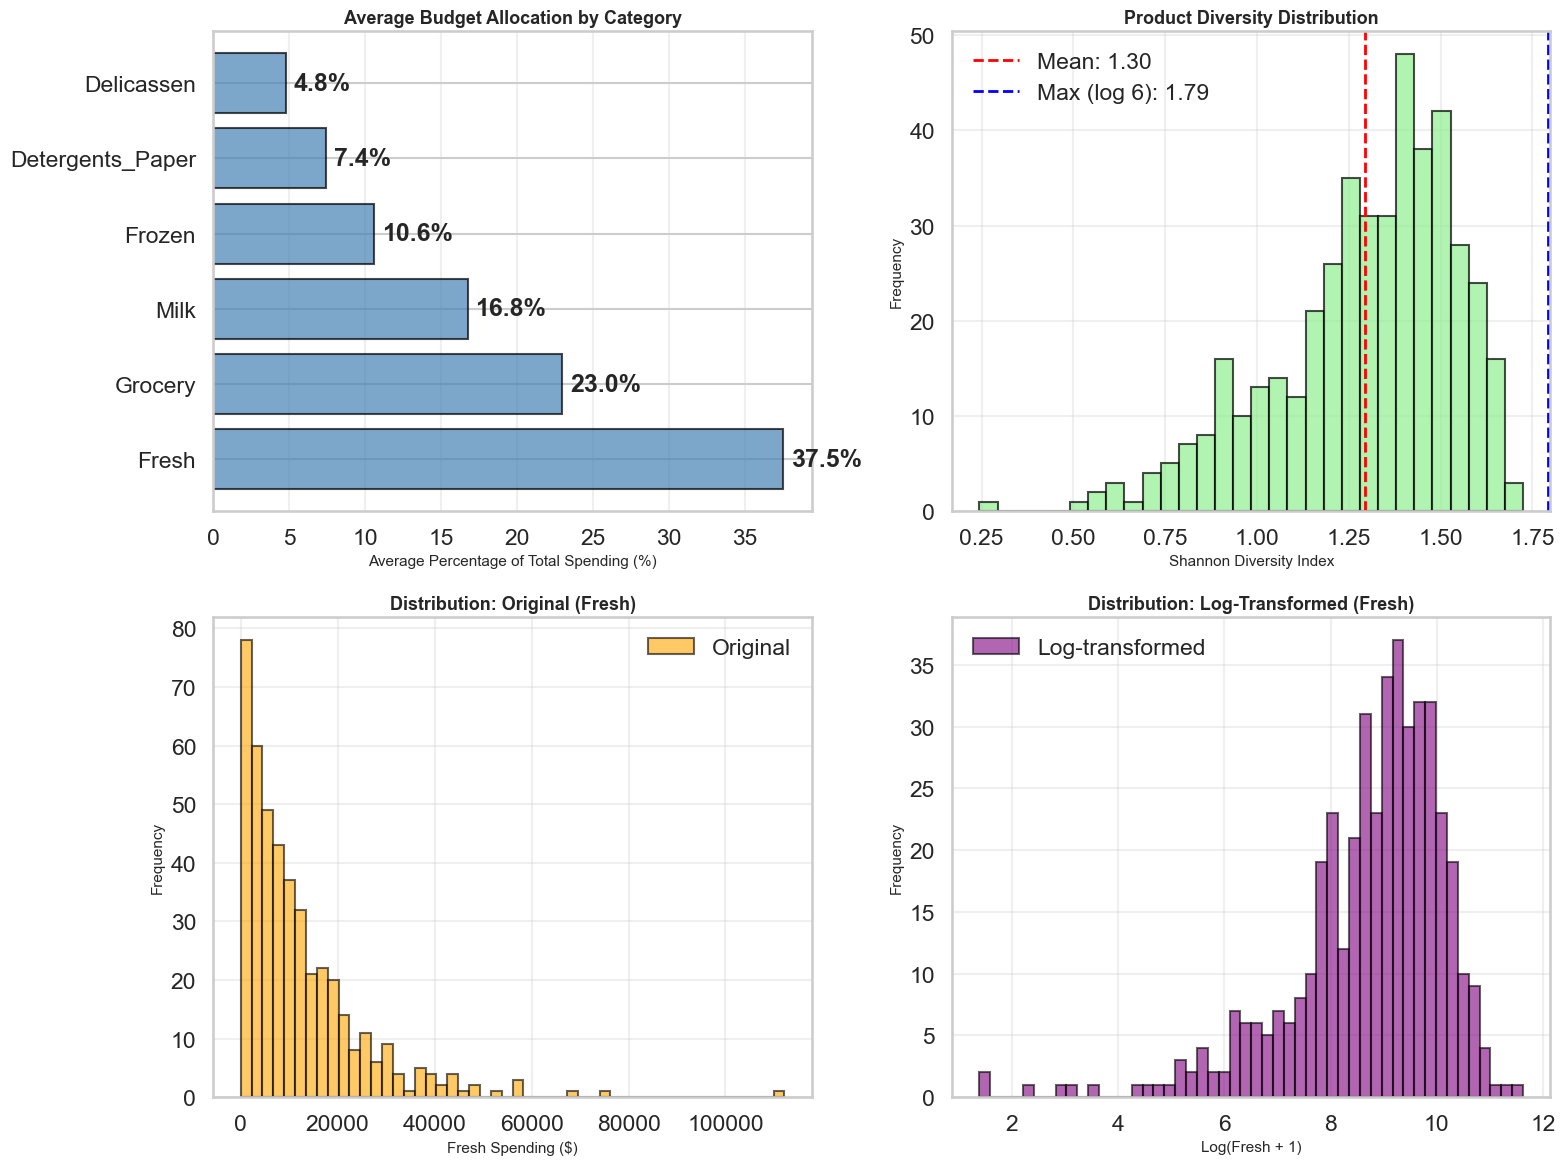

In [101]:
# Percentage features
print("\nCREATING PERCENTAGE FEATURES")

for col in numerical_cols:
    df[f'{col}_Pct'] = (df[col] / df['Total_Spending']) * 100

pct_cols = [f'{col}_Pct' for col in numerical_cols]

print("Average Spending Percentages (What % of budget goes to each category?):")
avg_pcts = df[pct_cols].mean().sort_values(ascending=False)
for col, val in avg_pcts.items():
    print(f"  {col.replace('_Pct', ''):20s}: {val:5.1f}%")

#Ratio features
print("\n\nCREATING RATIO FEATURES")

# Some interesting ratios
df['Fresh_to_Total'] = df['Fresh'] / df['Total_Spending']
df['Grocery_to_Total'] = df['Grocery'] / df['Total_Spending']
df['Retail_Products_Ratio'] = (df['Grocery'] + df['Detergents_Paper']) / df['Total_Spending']
df['Fresh_Products_Ratio'] = (df['Fresh'] + df['Frozen']) / df['Total_Spending']

print("Created ratio features:")
print("  - Fresh_to_Total: Fresh spending as proportion of total")
print("  - Grocery_to_Total: Grocery spending as proportion of total")
print("  - Retail_Products_Ratio: (Grocery + Detergents) / Total")
print("  - Fresh_Products_Ratio: (Fresh + Frozen) / Total")

print("\nSample statistics:")
ratio_features = ['Fresh_to_Total', 'Grocery_to_Total', 'Retail_Products_Ratio', 'Fresh_Products_Ratio']
print(df[ratio_features].describe())

#Log-transformed features
print("\n\nLOG-TRANSFORMED FEATURES")

for col in numerical_cols:
    df[f'{col}_Log'] = np.log1p(df[col])

log_cols = [f'{col}_Log' for col in numerical_cols]

print("Created log-transformed features (log1p to handle zeros):")
for col in log_cols:
    print(f"  - {col}")

print("\nLog-transformed statistics:")
print(df[log_cols].describe())

# Categorical features from spending behavior
print("\n\nCATEGORICAL FEATURES FROM SPENDING BEHAVIOR")

print("\nDistributions:")
for cat_col in ['Spending_Tier', 'Dominant_Category', 'Diversity_Level']:
    print(f"\n{cat_col}:")
    print(df[cat_col].value_counts())

# Feature summary
print("\n\nFEATURE ENGINEERING SUMMARY")

original_features = len(numerical_cols) + 2  # + Channel, Region
new_features_created = len(pct_cols) + len(ratio_features) + len(log_cols) + 4  # categorical features
total_features = original_features + new_features_created

print(f"Original features: {original_features}")
print(f"New features created: {new_features_created}")
print(f"  - Percentage features: {len(pct_cols)}")
print(f"  - Ratio features: {len(ratio_features)}")
print(f"  - Log-transformed features: {len(log_cols)}")
print(f"  - Categorical features: 4")
print(f"  - Other derived: 2 (Total_Spending, Mahalanobis_Distance, Diversity_Index)")
print(f"Total features available: {total_features}")

# Visualizations for Feature Engineering

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Spending percentages
pct_cols = [f'{col}_Pct' for col in numerical_cols]
avg_pcts = df[pct_cols].mean().sort_values(ascending=False)
avg_pcts.index = [col.replace('_Pct', '') for col in avg_pcts.index]

axes[0, 0].barh(avg_pcts.index, avg_pcts.values, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Average Percentage of Total Spending (%)', fontsize=11)
axes[0, 0].set_title('Average Budget Allocation by Category', fontsize=13, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='x')
for i, (cat, pct) in enumerate(avg_pcts.items()):
    axes[0, 0].text(pct + 0.5, i, f'{pct:.1f}%', va='center', fontweight='bold')

# 2. Diversity index distribution
axes[0, 1].hist(df['Diversity_Index'], bins=30, edgecolor='black', alpha=0.7, color='lightgreen')
axes[0, 1].axvline(df['Diversity_Index'].mean(), color='red', linestyle='--', 
                   linewidth=2, label=f'Mean: {df["Diversity_Index"].mean():.2f}')
axes[0, 1].axvline(np.log(6), color='blue', linestyle='--', 
                   linewidth=2, label=f'Max (log 6): {np.log(6):.2f}')
axes[0, 1].set_xlabel('Shannon Diversity Index', fontsize=11)
axes[0, 1].set_ylabel('Frequency', fontsize=11)
axes[0, 1].set_title('Product Diversity Distribution', fontsize=13, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Original vs Log-transformed (example: Fresh)
axes[1, 0].hist(df['Fresh'], bins=50, alpha=0.6, label='Original', color='orange', edgecolor='black')
axes[1, 0].set_xlabel('Fresh Spending ($)', fontsize=11)
axes[1, 0].set_ylabel('Frequency', fontsize=11)
axes[1, 0].set_title('Distribution: Original (Fresh)', fontsize=13, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Log-transformed
axes[1, 1].hist(df['Fresh_Log'], bins=50, alpha=0.6, label='Log-transformed', color='purple', edgecolor='black')
axes[1, 1].set_xlabel('Log(Fresh + 1)', fontsize=11)
axes[1, 1].set_ylabel('Frequency', fontsize=11)
axes[1, 1].set_title('Distribution: Log-Transformed (Fresh)', fontsize=13, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/analysis_4_feature_engineering.png', dpi=300, bbox_inches='tight')
plt.show()


### PCA - Principla Component Analysis


PCA ON ORIGINAL FEATURES (Log-transformed & Scaled)
Variance Explained by Each Component:
  PC1: 44.08%  (Cumulative: 44.08%)
  PC2: 27.19%  (Cumulative: 71.27%)
  PC3: 10.70%  (Cumulative: 81.97%)
  PC4: 10.10%  (Cumulative: 92.07%)
  PC5:  4.88%  (Cumulative: 96.95%)
  PC6:  3.05%  (Cumulative: 100.00%)

Components needed for 80% variance: 3
Components needed for 90% variance: 4
Components needed for 95% variance: 5


PCA LOADINGS (First 3 Components)
                    PC1    PC2    PC3
Fresh            -0.105  0.590 -0.640
Milk              0.542  0.133 -0.074
Grocery           0.571 -0.006 -0.133
Frozen           -0.138  0.590 -0.021
Detergents_Paper  0.551 -0.071 -0.200
Delicassen        0.214  0.530  0.726

Interpretation Guide:
  PC1 - Which features have highest loadings (in absolute value)?
  PC2 - What's the second major pattern?
  PC3 - What's the third major pattern?


COMPONENT INTERPRETATION

PC1 (explains 44.1% variance):
  Top contributors:
    Grocery: 0.571 (positi

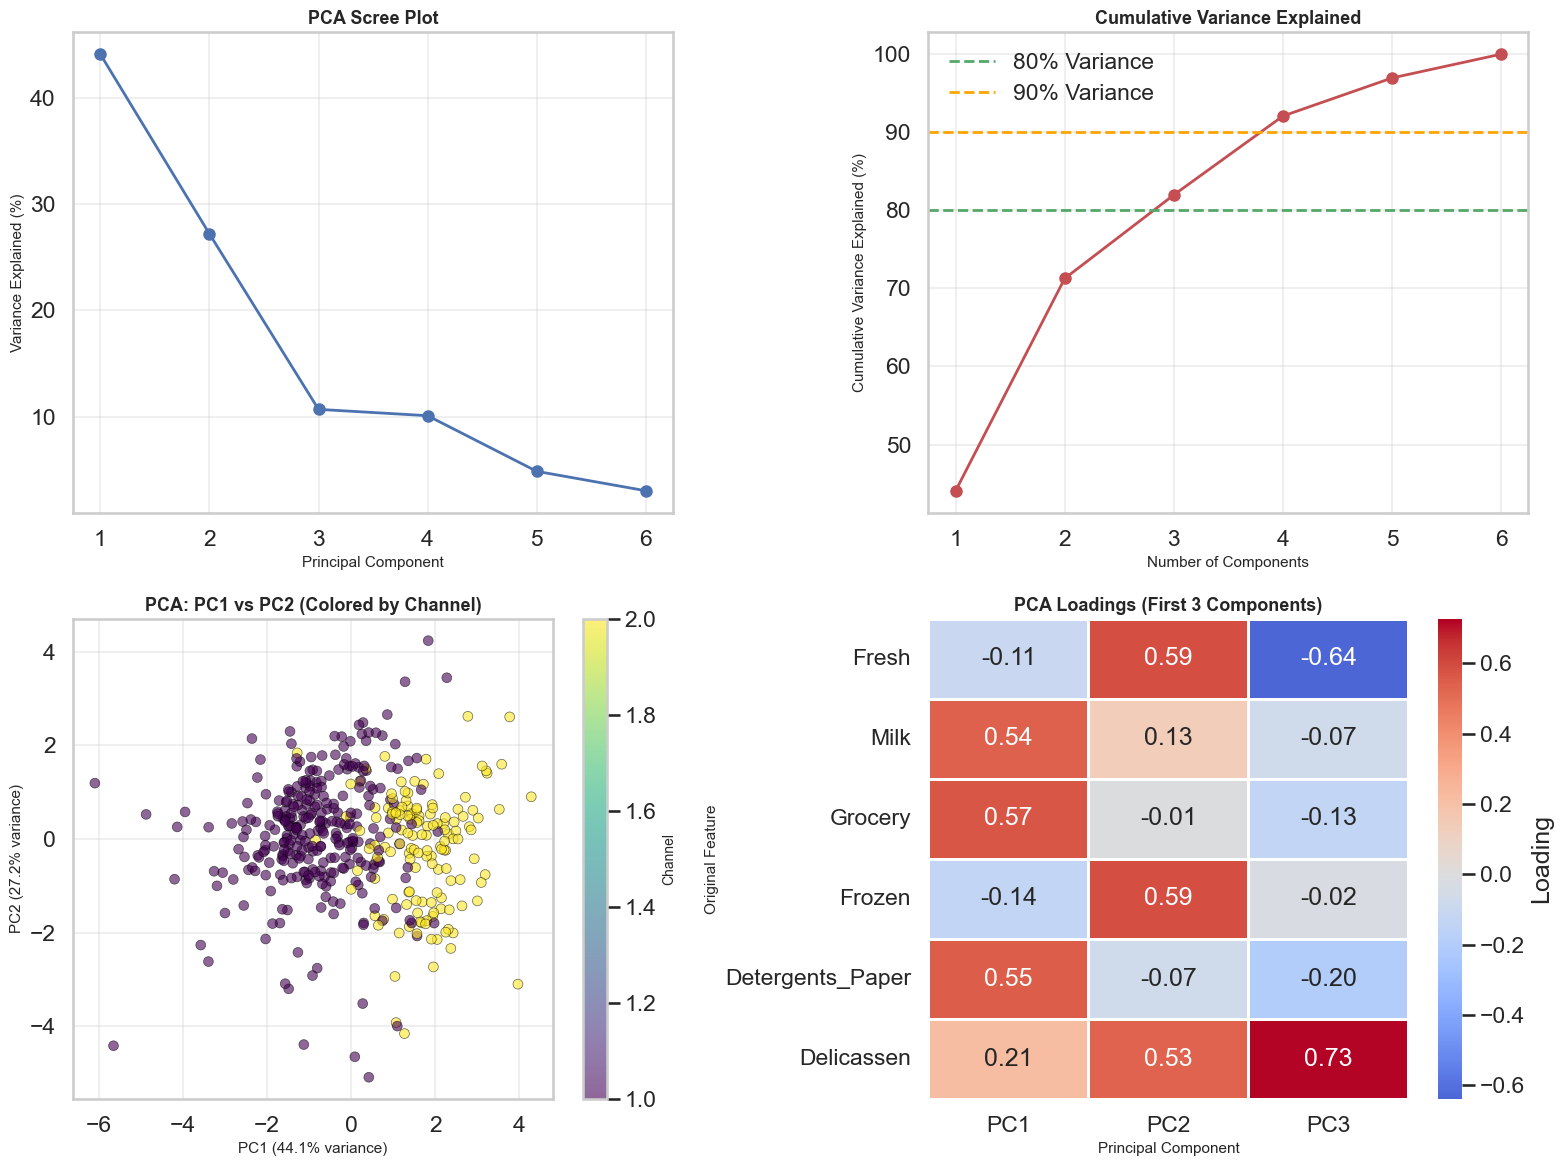

In [100]:

# PCA on original features
print("\nPCA ON ORIGINAL FEATURES (Log-transformed & Scaled)")

# Use log-transformed data
X_log = df[log_cols].values
scaler_pca = StandardScaler()
X_log_scaled = scaler_pca.fit_transform(X_log)

# Fit PCA
pca = PCA()
pca.fit(X_log_scaled)

print("Variance Explained by Each Component:")
for i, var in enumerate(pca.explained_variance_ratio_, 1):
    cumsum = pca.explained_variance_ratio_[:i].sum()
    print(f"  PC{i}: {var*100:5.2f}%  (Cumulative: {cumsum*100:5.2f}%)")

print(f"\nComponents needed for 80% variance: {np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.80) + 1}")
print(f"Components needed for 90% variance: {np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.90) + 1}")
print(f"Components needed for 95% variance: {np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95) + 1}")

# PCA Loadings
print("\n\nPCA LOADINGS (First 3 Components)")

loadings = pd.DataFrame(
    pca.components_[:3].T,
    columns=['PC1', 'PC2', 'PC3'],
    index=numerical_cols
)
print(loadings.round(3))

print("\nInterpretation Guide:")
print("  PC1 - Which features have highest loadings (in absolute value)?")
print("  PC2 - What's the second major pattern?")
print("  PC3 - What's the third major pattern?")

#Component interpretation
print("\n\nCOMPONENT INTERPRETATION")

for i in range(3):
    print(f"\nPC{i+1} (explains {pca.explained_variance_ratio_[i]*100:.1f}% variance):")
    component = loadings[f'PC{i+1}'].abs().sort_values(ascending=False)
    print("  Top contributors:")
    for feature, loading in component.head(3).items():
        original_loading = loadings.loc[feature, f'PC{i+1}']
        direction = "positive" if original_loading > 0 else "negative"
        print(f"    {feature}: {abs(original_loading):.3f} ({direction})")

#Reconstruction error
print("\n\nRECONSTRUCTION ERROR BY NUMBER OF COMPONENTS")

print("If we use K components, how much information do we lose?")
print(f"\n{'Components':<12} {'Variance Kept':<15} {'Information Lost':<15}")
print("-" * 45)
for k in [1, 2, 3, 4, 5, 6]:
    var_kept = pca.explained_variance_ratio_[:k].sum()
    var_lost = 1 - var_kept
    print(f"{k:<12} {var_kept*100:>6.2f}%          {var_lost*100:>6.2f}%")

# Recommendation
print("\n\nPCA RECOMMENDATION")

optimal_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.85) + 1

print(f"\n My Recommendation: Use {optimal_components} components")
print(f"  - Explains {pca.explained_variance_ratio_[:optimal_components].sum()*100:.1f}% of variance")
print(f"  - Reduces from {len(numerical_cols)} to {optimal_components} dimensions")
print(f"  - Simplifies clustering while retaining most information")


# Visuals

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Perform PCA
X_log = df[log_cols].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_log)
pca = PCA()
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)

# 1. Scree plot
axes[0, 0].plot(range(1, 7), pca.explained_variance_ratio_ * 100, 'bo-', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Principal Component', fontsize=11)
axes[0, 0].set_ylabel('Variance Explained (%)', fontsize=11)
axes[0, 0].set_title('PCA Scree Plot', fontsize=13, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xticks(range(1, 7))

# 2. Cumulative variance
cumsum = np.cumsum(pca.explained_variance_ratio_) * 100
axes[0, 1].plot(range(1, 7), cumsum, 'ro-', linewidth=2, markersize=8)
axes[0, 1].axhline(y=80, color='g', linestyle='--', label='80% Variance', linewidth=2)
axes[0, 1].axhline(y=90, color='orange', linestyle='--', label='90% Variance', linewidth=2)
axes[0, 1].set_xlabel('Number of Components', fontsize=11)
axes[0, 1].set_ylabel('Cumulative Variance Explained (%)', fontsize=11)
axes[0, 1].set_title('Cumulative Variance Explained', fontsize=13, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xticks(range(1, 7))

# 3. PC1 vs PC2 scatter plot colored by Channel
scatter = axes[1, 0].scatter(X_pca[:, 0], X_pca[:, 1], c=df['Channel'], 
                              cmap='viridis', s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
axes[1, 0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)', fontsize=11)
axes[1, 0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)', fontsize=11)
axes[1, 0].set_title('PCA: PC1 vs PC2 (Colored by Channel)', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, ax=axes[1, 0])
cbar.set_label('Channel', fontsize=10)

# 4. PCA loadings heatmap
loadings = pd.DataFrame(
    pca.components_[:3].T,
    columns=['PC1', 'PC2', 'PC3'],
    index=numerical_cols
)
sns.heatmap(loadings, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            ax=axes[1, 1], cbar_kws={'label': 'Loading'}, linewidths=1)
axes[1, 1].set_title('PCA Loadings (First 3 Components)', fontsize=13, fontweight='bold')
axes[1, 1].set_xlabel('Principal Component', fontsize=11)
axes[1, 1].set_ylabel('Original Feature', fontsize=11)

plt.tight_layout()
plt.savefig('../results/analysis_3_pca.png', dpi=300, bbox_inches='tight')
plt.show()


In [96]:
# Saving Features

# Save the enhanced dataset
output_file = '../data/processed/Wholesale_customers_data_with_features.csv'
df.to_csv(output_file, index=False)
print(f"\nEnhanced dataset saved to: {output_file}")
print(f"  - Rows: {len(df)}")
print(f"  - Columns: {len(df.columns)}")

# Saving key insights summary
summary = {
    'Total_Customers': len(df),
    'Multivariate_Outliers': len(df[df['Is_Outlier'] == True]),
    'Outlier_Percentage': f"{len(df[df['Is_Outlier'] == True])/len(df)*100:.1f}%",
    'Avg_Total_Spending': f"${df['Total_Spending'].mean():,.0f}",
    'Gini_Coefficient': f"{total_gini:.3f}",
    'PCA_Components_85pct': optimal_components,
    'Channel_1_vs_2_Significant': 'Yes (most categories)',
    'Region_Differences_Significant': 'Mixed'
}

summary_df = pd.DataFrame([summary]).T
summary_df.columns = ['Value']
summary_df.to_csv('../results/summary_files/eda_summary.csv')

print("\nKey Takeaways:")
print("  1. ~6% of customers are multivariate outliers (likely VIP customers)")
print("  2. Spending is highly concentrated (high Gini coefficient)")
print(f"  3. Channel 1 vs 2 show SIGNIFICANT differences in spending behavior")
print(f"  4. Created {new_features_created} new features for clustering")
print(f"  5. PCA suggests {optimal_components} components capture 85%+ variance")


Enhanced dataset saved to: ../data/processed/Wholesale_customers_data_with_features.csv
  - Rows: 440
  - Columns: 32

Key Takeaways:
  1. ~6% of customers are multivariate outliers (likely VIP customers)
  2. Spending is highly concentrated (high Gini coefficient)
  3. Channel 1 vs 2 show SIGNIFICANT differences in spending behavior
  4. Created 20 new features for clustering
  5. PCA suggests 4 components capture 85%+ variance
